In [1]:
import pandas as pd
import numpy as np
from numpy import array
import keras
from skimage.io import imshow
from sklearn import metrics as mt
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from keras.layers import Reshape
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import seaborn as sns
from keras.models import load_model
import random
import h5py
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import tensorflow as tf

/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)

1.8.0
2.2.0


In [3]:
#Example of cade to load the data generated from hdf5
hdf5_f = h5py.File("./Data/characters_all_64x64.hdf5", mode='r')

X = hdf5_f["X_train_aug"]
y = hdf5_f["y_train_aug"]
# print(X.shape, y.shape)
X_train = np.copy(X)
y_train = np.copy(y)

X = hdf5_f["X_test_aug"]
y = hdf5_f["y_test_aug"]
# print(X.shape, y.shape)
X_test = np.copy(X)
y_test = np.copy(y)

hdf5_f.close()

Flip close brackets to produce open brackets

In [4]:
# find close brackets
close_bracket_indices = list(np.where(y_train == ord(']'))[0])

# take random sample
random.shuffle(close_bracket_indices)
close_bracket_indices = close_bracket_indices[:int(len(close_bracket_indices)/2)]

for i in close_bracket_indices:
    X_train[i] = np.fliplr(X_train[i])
    y_train[i] = ord('[')
    
    
# find close brackets
close_bracket_indices = list(np.where(y_test == ord(']'))[0])

# take random sample
random.shuffle(close_bracket_indices)
close_bracket_indices = close_bracket_indices[:int(len(close_bracket_indices)/2)]

for i in close_bracket_indices:
    X_test[i] = np.fliplr(X_train[i])
    y_test[i] = ord('[')    

In [5]:
one_hot = LabelBinarizer()
y_train_ohe = one_hot.fit_transform(y_train)
y_test_ohe = one_hot.fit_transform(y_test)
y_train_ohe.shape

(2705457, 89)

In [6]:
classes = [chr(x) for x in sorted(set(y_test))]

In [7]:
img_wh = 64
NUM_CLASSES = len(classes)

Convert to channels last

In [8]:
X_train.shape

X_train = np.transpose(X_train, (0,2,3,1))
X_test = np.transpose(X_test, (0,2,3,1))

In [9]:
X_test.shape

(680133, 64, 64, 1)

In [10]:
# normalize to 0..1
X_train = (X_train - X_train.min())/(X_train.max() - X_train.min())
X_test = (X_test - X_test.min())/(X_test.max() - X_test.min())

In [11]:
X_test.shape

(680133, 64, 64, 1)

B


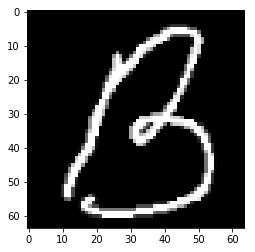

In [12]:
# CHANNELS LAST!
i=3
print(chr(y_test[i]))
plt.imshow(X_test[i,:,:,0].astype(np.float32), cmap='gray')
plt.show()

In [ ]:
# datagen = ImageDataGenerator(featurewise_center=False,
#     samplewise_center=False,
#     featurewise_std_normalization=False,
#     samplewise_std_normalization=False,
#     zca_whitening=False,
#     rotation_range=5, # used, Int. Degree range for random rotations.
#     width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
#     height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
#     shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
#     zoom_range=0.,
#     channel_shift_range=0.,
#     fill_mode='nearest',
#     cval=0.,
#     horizontal_flip=False,
#     vertical_flip=False,
#     rescale=None,
#     data_format="channels_last")

# datagen.fit(X_train)

In [ ]:
# cnn = Sequential()
# cnn.add(Conv2D(filters=32,
#                 input_shape = (img_wh,img_wh, 1),
#                 kernel_size=(3,3), 
#                 padding='same', 
#                 activation='relu')) # more compact syntax

# cnn.add(Conv2D(filters=64,
#                 kernel_size=(3,3), 
#                 padding='same', 
#                 activation='relu')) # more compact syntax
# cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# # add one layer on flattened output
# cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
# cnn.add(Flatten())
# cnn.add(Dense(128, activation='relu'))
# cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
# cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# # cnn.summary()

In [ ]:
%%time

from keras.layers import average, concatenate
from keras.models import Input, Model

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens = Model(inputs=input_holder,outputs=x)

cnn_ens.summary()

In [ ]:
# Let's train the model 
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='adam', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
# cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
#                    steps_per_epoch=int(len(X_train)/1024), # how many generators to go through per epoch
#                    epochs=100,
#                    validation_data=(X_test, y_test_ohe)
#                   )

cnn_ens.fit(X_train, y_train_ohe, batch_size=128,
            epochs=100, verbose=1,
            validation_data=(X_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
            )

In [15]:
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(70,30))
    plt.rcParams.update({'font.size': 12})
    yhat = [classes[i] for i in np.argmax(net.predict(X_test), axis=-1)]
    acc = mt.accuracy_score([chr(i) for i in y_test],yhat)
    
    cm = mt.confusion_matrix([chr(i) for i in y_test], yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
    plt.title("CNN: "+'{:.4f}'.format(acc))
    plt.savefig("confusion_matrix.jpg")
    plt.show()

In [ ]:
summarize_net(cnn, X_test, y_test, title_text='CNN:')

In [ ]:
# save model to disk
cnn.save('cnn_100.h5')

----

_____________

Import model from disk:

In [13]:
from keras.models import load_model

model = load_model('cnn2_100_early.h5')

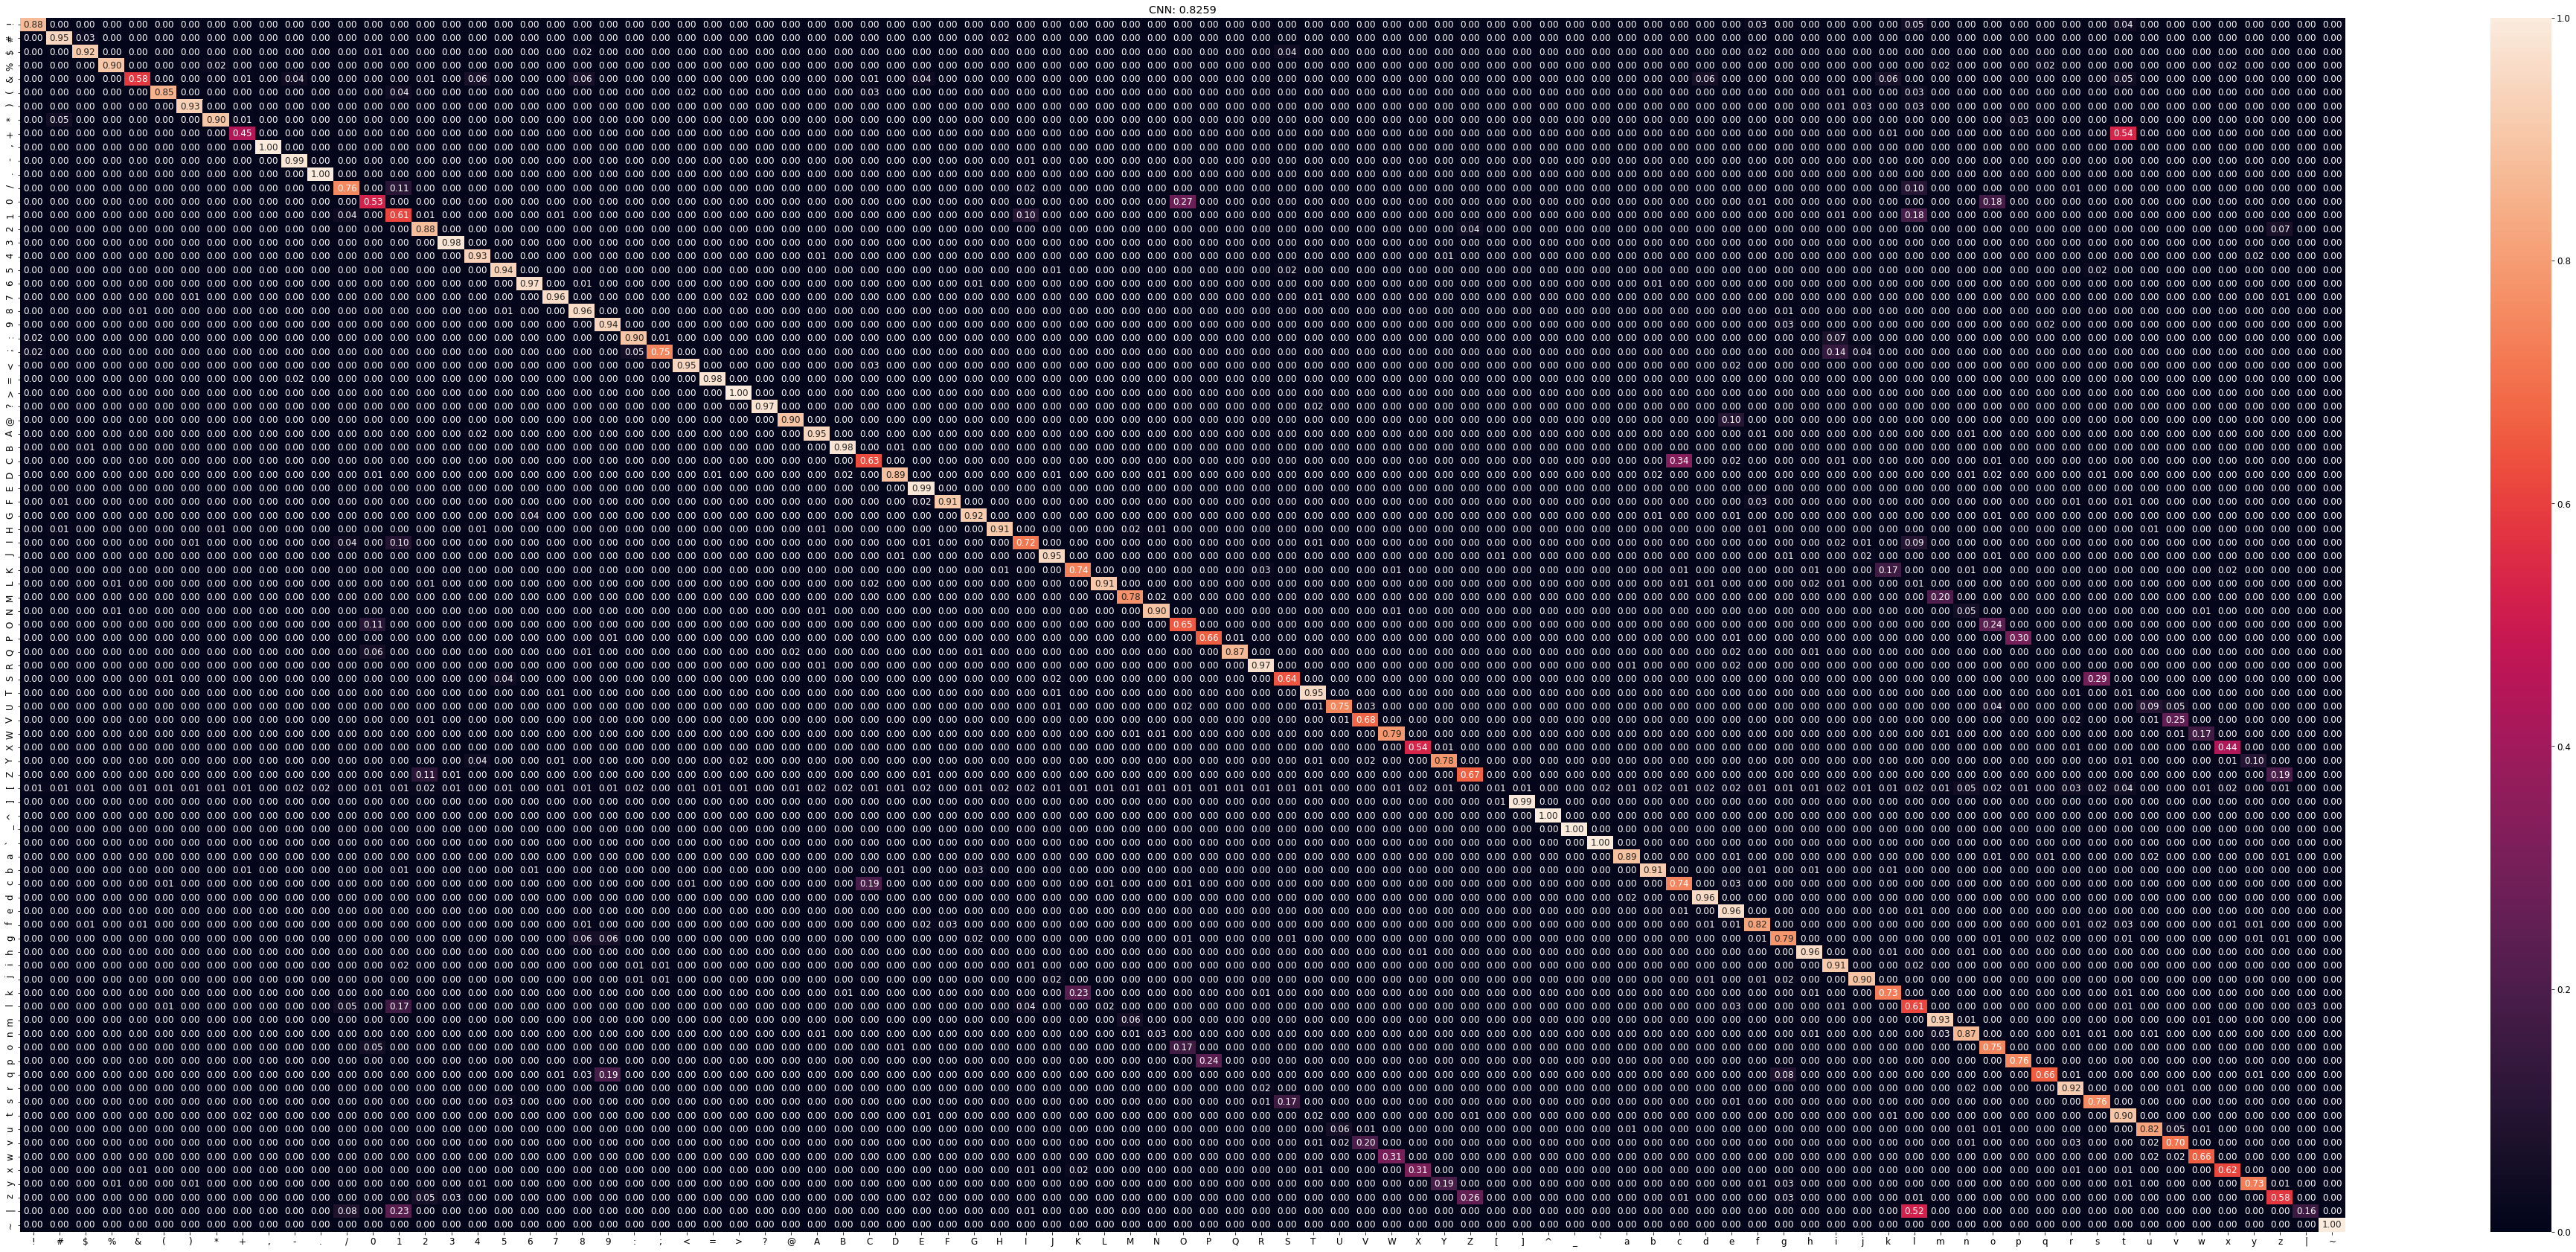

In [16]:
summarize_net(model, X_test, y_test, title_text='CNN:')